# Documentação do Python em Português: O que já foi traduzido?

Essa análise visa entender melhor o quão distante estamos de 1) traduzir a documentação do Python por inteiro e 2) ter o mínimo traduzido para ser publicado no site oficial. 

Como eu não tenho experiência com ferramentas de análise de dados e para facilitar contribuições/melhorias, optei por usar o Jupyter e disponibilizar o código no Github. Então caso você tenha alguma ideia de análise que poderia ser feita ou uma sugestão de como melhorar o que eu fiz até aqui, me mande uma mensage ou até mesmo abra um Pull Request lá no [Github](http://github.com/rougeth/python-doc-br-stats) (Caso precise de ajuda, [clique aqui](https://leportella.com/pt-br/2017/04/17/como-contribuir-com-open-source.html)) \o/.

## Setup

Para reproduzir esse notebook, é preciso ter o `jupyter` instalado, além das bibliotecas `requests` e `matplotlib`. Se você tiver `pipenv` instalado, o comando `pipenv install` já instala todas as dependências necessárias. Caso não `pip install jupyter requests matplotlib` deve resolver.

Començando com o notebook, importo as bibliotecas necessárias, em especial a `helper`, que contém funções, constantes, etc, que foram criadas para ~~esconder as gambiarras~~ organizar melhor o notebook. E também configuro algumas opções "globais" do `matplotlib`.

In [11]:
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import helper

%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')

## Requisitando os dados no Transifex

Para fazer as requisições na [API do Transifex](https://docs.transifex.com/api/), criei a função `helper.transifex_api`, que nada mais é do que uma camada a cima da biblioteca `requests`. Nela já configuro autenticação e a url da API, tornando as requisições um pouco mais simples.

Caso você queira executar esse notebook, é preciso definir a variável de ambiente `TRANSIFEX_API_TOKEN` com o valor do token que você gerar no Transifex (veja [aqui](https://docs.transifex.com/api/introduction#authentication) como fazer parar gerar um novo token). Você pode fazer isso antes de executar o notebook:

```shell
$ export TRANSIFEX_API_TOKEN="token"
$ jupyter notebook
```

No Transifex existe o conceito de *resource*, que, no caso da documentação do Python, são as páginas ou seções da documentação, como por exemplo, [What's new in Python 3.7?](https://docs.python.org/3/whatsnew/3.7.html) ou [Library Reference](https://docs.python.org/3/library/index.html). O *endpoint* `resources/` retorna todas as seções disponíveis no Transifex. A resposta contém diversas informações sobre cada seção, porém gero uma lista apenas com os *slugs*, que serão usados nas próximas requisições.

In [2]:
resources = helper.transifex_api("resources/")
resources = [resource["slug"] for resource in resources]

Para cada uma das seções, acesso as estatísticas básicas que o Transifex disponibiliza. Para a análise, é preciso da quantidade de entidades traduzidas, não traduzidas e revisadas. Uma entidade pode ser uma simples frase até um parágrafo inteiro, depende mesmo de como a documentação foi organizada.

No Transifex não existe o conceito de subseção ou subpágina, então, por exemplo, os tutoria sobre `if` e sobre `for` são considerados seções diferentes, mesmo sendo tutoriais. Como não é necessário analisar nesse nível de especificidade, agrupo as estatísticas na seção raíz.

In [3]:
stats = defaultdict(lambda: {
    "entities": 0,
    "translated_entities": 0,
    "reviewed_entities": 0,
    "translated_words": 0,
    "untranslated_words": 0,
})
for resource in resources:
    stat = helper.transifex_api(f"resource/{resource}/stats/pt_BR/")
    
    # Group stats considering the first part of slug.
    # Transform "c-api--abstract" and "c-api--allocation" into "c-api".
    resource = resource.split('--')[0]
    
    stats[resource]["entities"] += (stat["translated_entities"]
                                    + stat["untranslated_entities"])
    stats[resource]["translated_entities"] += stat["translated_entities"]
    stats[resource]["reviewed_entities"] += stat["reviewed"]
    stats[resource]["translated_words"] += stat["translated_words"]
    stats[resource]["untranslated_words"] += stat["untranslated_words"]
    
stats = {key: stats[key] for key in sorted(stats.keys(), reverse=True)}

*Essa parte é maquiagem pura. Todas as seções nos gráficos de barra são de cor azul, exceto as seções que devem ser 100% traduzidas, que são de cor amarela.*

In [4]:
# Configure nice colors for the chart. I'm sure there is a better way to do it.
fill_palette, line_palette = helper.palette(stats.keys())

## O que já foi traduzido?

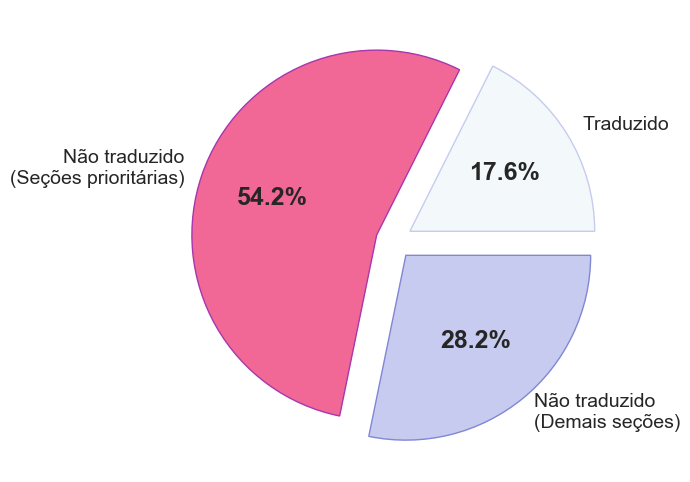

In [12]:
priorities_not_translated = sum(
    stat['entities']-stat['translated_entities']
    for resource, stat in stats.items()
    if resource in helper.REQUIRED_RESOURCES)

not_translated = sum(
    s['entities']-s['translated_entities']
    for s in stats.values()) - priorities_not_translated

translated = sum(s['translated_entities'] for s in stats.values())

figure, ax = plt.subplots(figsize=(12,6))

wedges, texts, autotexts = ax.pie(
    [translated, priorities_not_translated, not_translated],
    labels=["Traduzido", "Não traduzido\n(Seções prioritárias)",
            "Não traduzido\n(Demais seções)"],
    colors=["#f3f9fb", "#f16896", "#c6cbef"],
    autopct="%1.1f%%",
    explode=[0.1]*3,
)
plt.setp(autotexts, size=18, weight="bold")

edgecolors = ["#c6cbef", "#a836ad", "#8186d5"]
for index, color in enumerate(edgecolors):
    wedges[index].set_edgecolor(color)

plt.show()

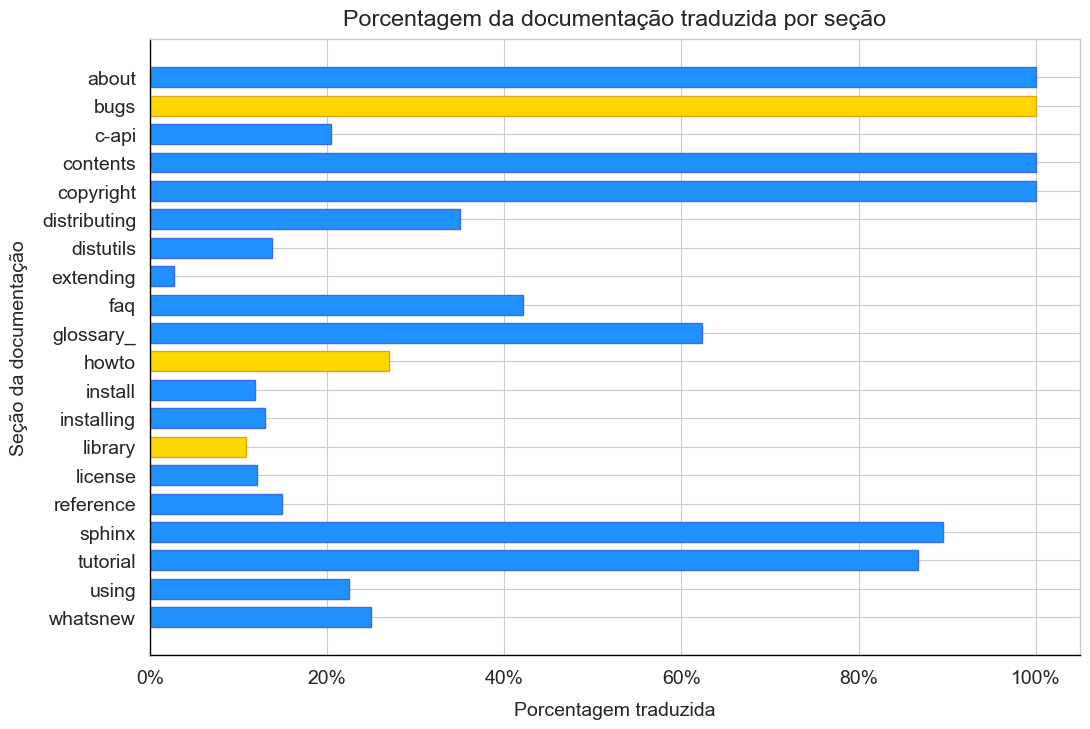

In [13]:
y_resources = list(stats.keys())
x_translated = [s['translated_entities']/s['entities'] for s in stats.values()]

figure, ax = plt.subplots(figsize=(12,8))

helper.setup_axes(ax)
ax.set_title("Porcentagem da documentação traduzida por seção", pad=10)
ax.set_xlabel("Porcentagem traduzida", labelpad=10)
ax.set_ylabel("Seção da documentação", labelpad=10)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.barh(y_resources, x_translated, height=0.7, color=fill_palette,
        edgecolor=line_palette)

plt.show()

## Quanto falta traduzir em cada seção?

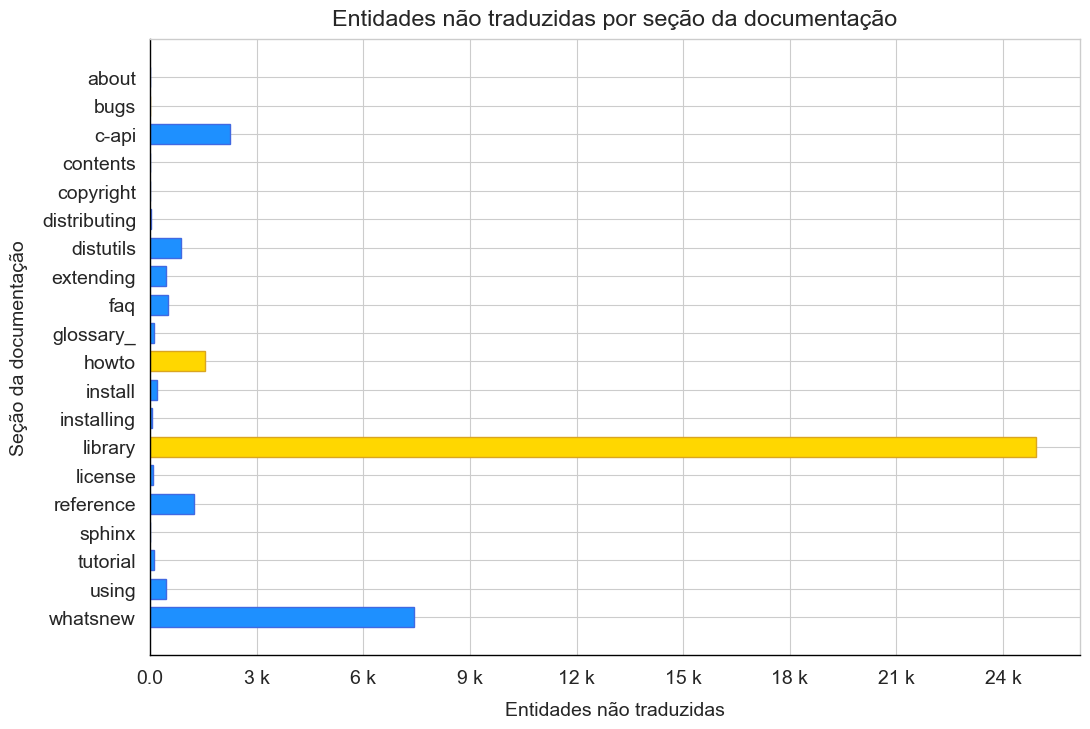

In [14]:
y_resources = list(stats.keys())
x_words = [s['entities']-s['translated_entities'] for s in stats.values()]

figure, ax = plt.subplots(figsize=(12,8))
helper.setup_axes(ax)

ax.set_title("Entidades não traduzidas por seção da documentação", pad=10)
ax.set_xlabel("Entidades não traduzidas", labelpad=10)
ax.set_ylabel("Seção da documentação", labelpad=10)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(helper.kilo_format))
ax.barh(y_resources, x_words, height=0.7, color=fill_palette, edgecolor=line_palette)

plt.show()

## E o que foi revisado?

In [8]:
total_entities = sum(s['translated_entities'] for s in stats.values())
total_reviewed = sum(s['reviewed_entities'] for s in stats.values())
pct_reviewed = total_reviewed / total_entities * 100
print(f"Entidades traduzidas e revisadas: {pct_reviewed:.2f}%")

Entidades traduzidas e revisadas: 0.03%


## Conclusões

- Bom, temos **muito** trabalho pela frente;
- Do pouco já traduzido, quase nada foi revisado;
- Das três seções necessárias para publicarmos a tradução, já temos uma 100% traduzida. Outra, *library*, além de ser a maior seção da documentação é também a que menos traduzimos;

O meu foco para o próximo passo será manter o Transifex sincronizado ao repositório no Github. Feito isso, começarei algumas discussões sobre como melhorar o processo de tradução para facilitar e engajar mais pessoas da comunidade a contribuirem.

o/